# Project: Lyft Competition

This project explores annotated object properties (location and dimensions) in the Lyft Level 5 dataset for autonomous driving, focusing on their distributions by class (car, truck, bus, bicycle, pedestrian, etc.).

## Overview

The dataset contains 3D bounding box annotations for multiple object types detected by autonomous vehicle sensors. Through visualizations including KDE joint plots, boxplots, and violin plots, we analyze spatial positions (center_x, center_y, center_z) and object dimensions (width, length, height) for each class. Heavy vehicles (truck, bus, other_vehicle) show greater spread and larger typical dimensions than cars, while pedestrians and bicycles are distinctively smaller and occupy tighter spatial regions. These patterns reflect real-world road structure and validate annotation quality.

## Key Research Questions

* How do object spatial positions (center_x, center_y, center_z) vary by class in autonomous driving scenes?
* What are the typical and outlier dimensions (width, length, height) for each annotated class?
* Are data distributions for each class consistent with real-world expectations?
* Can these statistics inform model design, class separability, and data quality assurance?
* How can multimodality and outliers in these features be used for robust detection and scene understanding?

## Credits and Citations

* https://github.com/lyft/nuscenes-devkit
* https://www.kaggle.com/code/tarunpaparaju/lyft-competition-understanding-the-data
* https://www.kaggle.com/gaborfodor/eda-3d-object-detection-challenge

# 1. Introduction:

The Lyft Level 5 dataset provides richly annotated 3D bounding boxes for a variety of object classes in urban driving scenes. Initial analysis shows significant and interpretable structure in the spatial location and physical properties of these objects, reflecting real-world lane usage, road organization, and expected dimensions. These insights motivate further research in autonomous vehicle perception and benchmarking for robust object detection models.

## 1.1 Importing Libraries

In [2]:
# Installations
# Uncomment if running on Kaggle or Colab to install required packages

!pip install lyft_dataset_sdk

# The upgrades below are because of a scipy error. This works so do not touch.
!pip install --upgrade numpy==1.26.4
!pip install --upgrade scipy==1.14.1
# !pip install --upgrade seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:0000:01
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 65.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
E

In [3]:
# System & Utilities
import os
import glob
import gc
import numpy as np
import pandas as pd
from pandas import json_normalize
import sys
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
import seaborn as sns
from PIL import Image
import cv2

# Lfyt Dataset SDK
# The Lyft Level 5 Dataset was released publicly for research on autonomous driving, similar to the nuScenes dataset by Motional. 
# In fact, lyft_dataset_sdk is built upon a modified version of the nuScenes devkit, which means its APIs and data structures are nearly identical.
import lyft_dataset_sdk
from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

# sklearn
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix

# Misc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random
import json
import pickle
from datetime import datetime
import math
import time
from typing import Tuple, List, Dict
from pyquaternion import Quaternion
from tqdm import tqdm # Tqdm is a popular Python library designed to provide fast, extensible progress bars for loops and iterable tasks. 
import struct
from abc import ABC, abstractmethod
from functools import reduce
import copy

## 1.2 Version Checks

In [4]:
?lyft_dataset_sdk

Type:        module
String form: <module 'lyft_dataset_sdk' from '/usr/local/lib/python3.11/dist-packages/lyft_dataset_sdk/__init__.py'>
File:        /usr/local/lib/python3.11/dist-packages/lyft_dataset_sdk/__init__.py
Docstring:   <no docstring>


As per the official documentation on <a href="https://pypi.org/project/lyft-dataset-sdk/0.0.8/">Lyft Dataset SDK 0.0.08</a>, this is the latest version which was updated in 2019. However, as it is based on the Nuscenes SDK, and there are many proven notebooks on Kaggle that can help a newbie learn "Object Detection", this notebook will continue to use this module for academic and research purpose.

## 1.3 User Variables

In [5]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # print(dirname)

In [6]:
os.listdir('/kaggle/input') # The above code goes into a big loop as there are too many files in the subdirs

['3d-object-detection-for-autonomous-vehicles']

In [7]:
common_path = "/kaggle/input/3d-object-detection-for-autonomous-vehicles/"
train_datasets_path = common_path + 'train.csv'
sample_submission_path = common_path + 'sample_submission.csv'

In [8]:
output_dir = '/kaggle/working/outputs'
os.makedirs(output_dir, exist_ok=True)

# 2. Codes

The scope of this notebook is to first learn the basics. The organization and decoration of the codes will be done in the future :)

## 2.1 Exploring training data

In [9]:
df_train = pd.read_csv(train_datasets_path)
df_sample_submission = pd.read_csv(sample_submission_path)

In [10]:
df_train.columns

Index(['Id', 'PredictionString'], dtype='object')

In [11]:
df_sample_submission.columns

Index(['Id', 'PredictionString'], dtype='object')

In [12]:
df_train.head()

,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


In [13]:
df_sample_submission.head()

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,NaN
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,NaN
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,NaN


In [14]:
df_train["Id"][0]

'db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce76edd4af4d04e49341'

In [15]:
df_train["PredictionString"][0]

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

In [16]:
df_train["PredictionString"][0].split()[:8]

['2680.2830359778527',
 '698.1969292852777',
 '-18.04776692365821',
 '2.064',
 '5.488',
 '2.053',
 '2.6041643845397946',
 'car']

In [17]:
df_train["PredictionString"][0].split()[8:16]

['2691.997461646401',
 '660.8016536569899',
 '-18.674258695658377',
 '1.818',
 '4.57',
 '1.608',
 '-0.33517602468486984',
 'car']

In [18]:
def retrieve_annotated_objects(df_train, df_train_index, number_of_annotated_objects, annotation_start):
    if 0 <= df_train_index < len(df_train):
        try:
            prediction_string_list = df_train.loc[df_train_index, "PredictionString"].split()
            _start = annotation_start
            _end = annotation_start + number_of_annotated_objects

            # Ensure the indices are within bounds
            if _end <= len(prediction_string_list):
                center_x, center_y, center_z, width, length, height, yaw, class_name = prediction_string_list[_start:_end]
                return center_x, center_y, center_z, width, length, height, yaw, class_name
            else:
                return "Error: Annotation indices exceed PredictionString length."
        except Exception as e:
            return f"Error processing annotation: {e}"
    else:
        return "Error: Invalid df_train_index."

In [19]:
center_x, center_y, center_z, width, length, height, yaw, class_name = retrieve_annotated_objects(df_train, 0, 8, 0)

print(f"center_x: {center_x}")
print(f"center_y: {center_y}")
print(f"center_z: {center_z}")
print(f"width: {width}")
print(f"length: {length}")
print(f"height: {height}")
print(f"yaw: {yaw}")
print(f"class_name: {class_name}")

center_x: 2680.2830359778527
center_y: 698.1969292852777
center_z: -18.04776692365821
width: 2.064
length: 5.488
height: 2.053
yaw: 2.6041643845397946
class_name: car


The annotation objects in the Lyft dataset's "PredictionString" are the 3D bounding boxes that represent various objects detected in the environment around the autonomous vehicle. Each annotated object describes a traffic agent or dynamic entity in the scene defined by the following fields in `train.csv`:

* `center_x`, `center_y` and `center_z` are the world coordinates of the center of the 3D bounding volume.
* `width`, `length` and `height` are the dimensions of the volume.
* `yaw` is the angle of the volume around the z axis (where y is forward/back, x is left/right, and z is up/down - making 'yaw' the direction the front of the vehicle / bounding box is pointing at while on the ground).
* `class_name` is the type of object contained by the bounding volume.

In [20]:
len(df_train["PredictionString"])

22680

In [21]:
number_of_annotated_objects = 8 # center_x, center_y, center_z, width, length, height, yaw, class_name

def count_objects(pred_string):
    if pd.isna(pred_string):
        return 0
    return len(pred_string.strip().split()) // number_of_annotated_objects

np.sum(df_train['PredictionString'].apply(count_objects))

638179

We have 638179 annotated objects in 22680 train samples.

In [22]:
def convert_df_actionable_insights(df_train):

    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    
    numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
    df_train_object_columns = numerical_cols + ['class_name']
    object_columns = ["sample_id"] + df_train_object_columns
    
    objects = []
    
    for sample_id, row in tqdm(df_train.values[:]):
        row_params = row.split()
        
        num_objects = len(row_params)
        number_of_annotated_objects = 8 # 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw', 'class_name'
        row_range = num_objects // number_of_annotated_objects
        
        for i in range(row_range):
            _start = i*8
            _end = (i+1)*8
            center_x, center_y, center_z, width, length, height, yaw, class_name = tuple(row_params[_start: _end])
    
            objects.append([sample_id, i, center_x, center_y, center_z, width, length, height, yaw, class_name])

    df_train_objects = pd.DataFrame(objects, columns = object_columns)

    # Convert string type to float32 for numerical columns
    df_train_objects[numerical_cols] = np.float32(df_train_objects[numerical_cols].values)

    return df_train_objects

In [23]:
df_train_objects = convert_df_actionable_insights(df_train)
df_train_objects.head(2)

100%|██████████| 22680/22680 [00:02<00:00, 9980.23it/s] 


,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car


We now have the training data with the appropriate columns and splits

## 2.2 EDA

### 2.2.1 Distributions of `center_x` and `center_y`

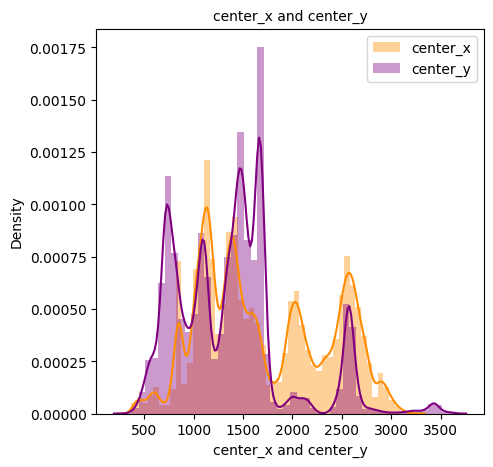

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

# "center_x" distribution plot
sns.distplot(
    df_train_objects['center_x'], 
    color='darkorange', 
    ax=ax,
    label="center_x").set_title('center_x and center_y', fontsize=10)

# "center_y" distribution plot
sns.distplot(
    df_train_objects['center_y'], 
    color='purple', 
    ax=ax,
    label="center_y").set_title('center_x and center_y', fontsize=10)

plt.xlabel('center_x and center_y', fontsize=10)
plt.legend()
plt.show()

### Notes

* Multiple Peaks:
    * Both the distributions have <strong>multiple peaks</strong> or <strong>multimodal</strong> distribution.
    * This implies that objects' centers often cluster at certain locations in the vehicle/environment coordinate space, reflecting structured scenes such as lanes, roads, and common object/vehicle trajectories.

* Overlap and Spread:
    * The plots for center_x and center_y have overlapping regions but with distinct peak placements and spreads.
    * This suggests regular patterns in where objects are found, but the density and location clusters differ along the x and y spatial axes.

* Density Magnitude:
    * The higher the density at a particular location (y-axis), the more often objects appear at that spatial value in the dataset.
    * Some positions are far more common, likely correlating with traffic lanes or common driveable space.

* Right Skew:
    * The main spread is between roughly 500 and 2500 for both axes, indicating most annotated objects fall within this spatial corridor.
    * The differences in density shapes can reveal the geometry of the road network, sensor perspective, or dataset collection bias.

### 2.2.2 KDE Plot: Relationship between `center_x` and `center_y`

A KDE plot (Kernel Density Estimate plot) is a method for visualizing the probability density function of a continuous variable, serving as a smoothed alternative to histograms. Instead of showing raw counts in bins, it estimates the probability density by averaging over 'kernels' (bell-shaped curves) centered at each data point, creating a continuous profile that reveals patterns and modes in your data.​

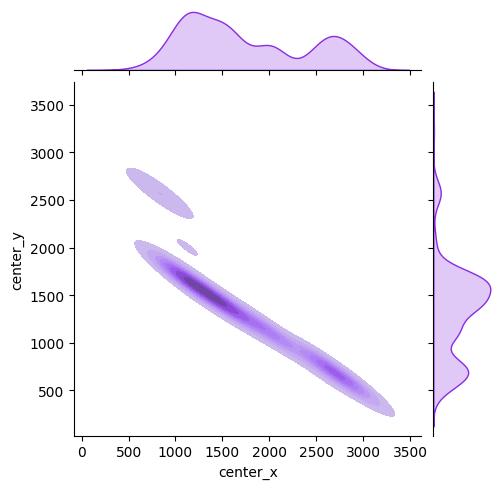

In [25]:
df_new_train_objects = df_train_objects.query('class_name == "car"')

plot = sns.jointplot(
    x=df_new_train_objects['center_x'][:1000],
    y=df_new_train_objects['center_y'][:1000], 
    kind='kde',
    color='blueviolet',
    fill=True,
    height=5)

plot.set_axis_labels('center_x', 'center_y', fontsize=10)
plt.show()

### Notes

* Object Detection distance limitations
    * Camera cannot detect objects that are both far ahead and far to the side.
    * Objects in these both extremities may not get detected at all.
    * Objects in one of these extremities may get detected.
    * Negative Correlation between `center_x` and `center_y`

### 2.2.3 Distribution of `center-z`

In [26]:
def plot_single_distplot(df, _x, _color):
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.distplot(
        df[_x],
        color=_color,
        ax=ax).set_title(_x, fontsize=10)
    
    plt.xlabel(_x, fontsize=10)
    plt.show()

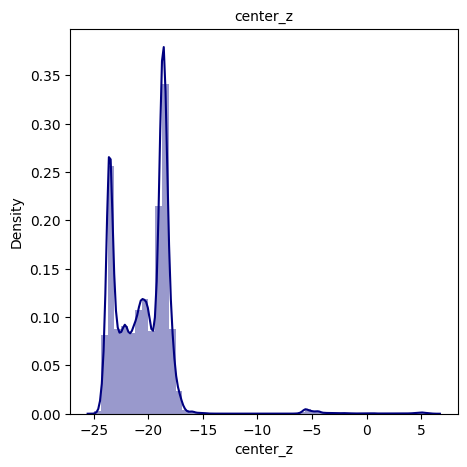

In [27]:
plot_single_distplot(df_train_objects, "center_z", "navy")

### Notes

* Right skew
    * Right positive skew
    * Clustered around `-20` mark -> mean value

* Variation is smaller than that of join plot of `center_x` and `center_y`
    * Most objects are very close to the flat plan of the road
    * Results in no great variation in the height of the objects above/below (z-axis) of the camera.

* Negative z-coordinates
    * Camera is attached on top of the car
    * Camera has to "look down" to see objects

### 2.2.4 Distribution of `yaw`

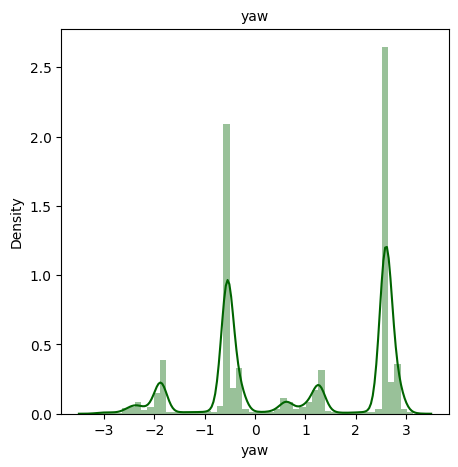

In [28]:
plot_single_distplot(df_train_objects, "yaw", "darkgreen")

## Notes

* Bimodal distribution
    * Two major peaks in the distribution: 0.5 and then 2.5
    * Mean is between 1 and 2

* No clear skew
    * The bimodal peaks reduces the skew in both directions, cancelling each other out
    * Balanced distribution

### 2.2.5 Distribution of `width`

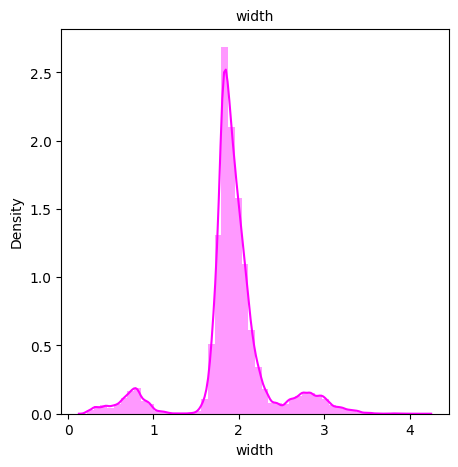

In [29]:
plot_single_distplot(df_train_objects, "width", "magenta")

### Notes

* Unimodal and Normal distributed
    * Mean is around 2
        * Majority of the objects are cars, around the mean
    * Outliers on both sides of the peak
        * Left Side: smaller objects: pedestrians, bicycles
        * Right Side: larger objects: trucks, vans

### 2.2.6 Distribution of `length`

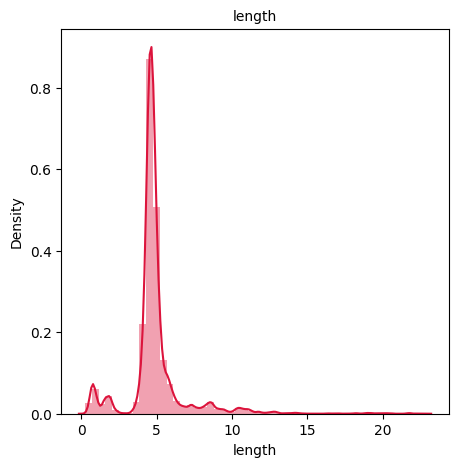

In [30]:
plot_single_distplot(df_train_objects, "length", "crimson")

### Notes

* Unimodal with Right skew
    * Mean is around 5
    * Majority of the objects are cars, around the mean

* Outliers on both sides of the peak
    * Left Side: smaller objects: pedestrians, bicycles
    * Right Side: larger objects: trucks, vans

### 2.2.7 Distribution of `height`

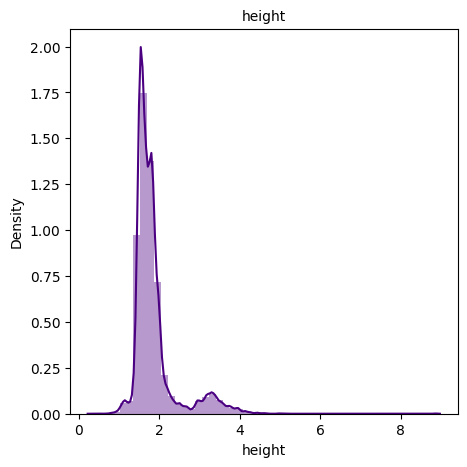

In [31]:
plot_single_distplot(df_train_objects, "height", "indigo")

### Notes

* Unimodal with Right skew
    * Mean is around 2
    * Majority of the objects are cars, around the mean

* Outliers on both sides of the peak
    * Left Side: smaller objects: pedestrians, bicycles
    * Right Side: larger objects: trucks, vans

### 2.2.8 Frequency of object classes

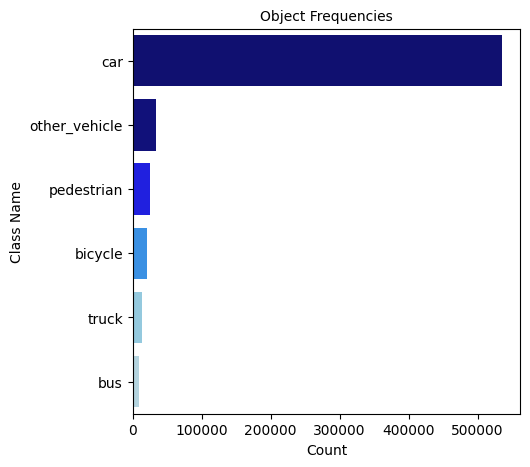

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

# Filter the dataframe
df_train_objects_filtered = df_train_objects.query(
    'class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'
)

# Get class counts and sort in descending order
class_counts = df_train_objects_filtered['class_name'].value_counts()
sorted_classes = class_counts.index.tolist()

plot = sns.countplot(
    y="class_name",
    data=df_train_objects_filtered,
    palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue'],
    order=sorted_classes).set_title('Object Frequencies', fontsize=10)

plt.yticks(fontsize=10)
plt.xlabel("Count", fontsize=10)
plt.ylabel("Class Name", fontsize=10)
plt.show(plot)

### Notes

* The most common object is `car`
    * Background of the data: Images were taken from the streets of Palo Alto, Silicon Valley, CA, USA
    * Car centric roads

### 2.2.9 `center_x` vs `class_name`

In [33]:
def comparison_plots(df, _x, _y, _query, _palette, _title, type_of_plot="violinplot"):

    fig, ax = plt.subplots(figsize=(8, 8))

    if type_of_plot == "violinplot":
        plot = sns.violinplot(
            x=_x,
            y=_y,
            data=df.query(_query),
            palette=_palette,
            split=True,
            ax=ax).set_title(_title, fontsize=10)
    elif type_of_plot == "boxplot":
        plot = sns.boxplot(
            x=_x,
            y=_y,
            data=df.query(_query),
            palette=_palette,
            ax=ax).set_title(_title, fontsize=10)
    else:
        print("Choose: violinplot or boxplot!")
    
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.xlabel(_x, fontsize=10)
    plt.ylabel(_y, fontsize=10)
    plt.show(plot)

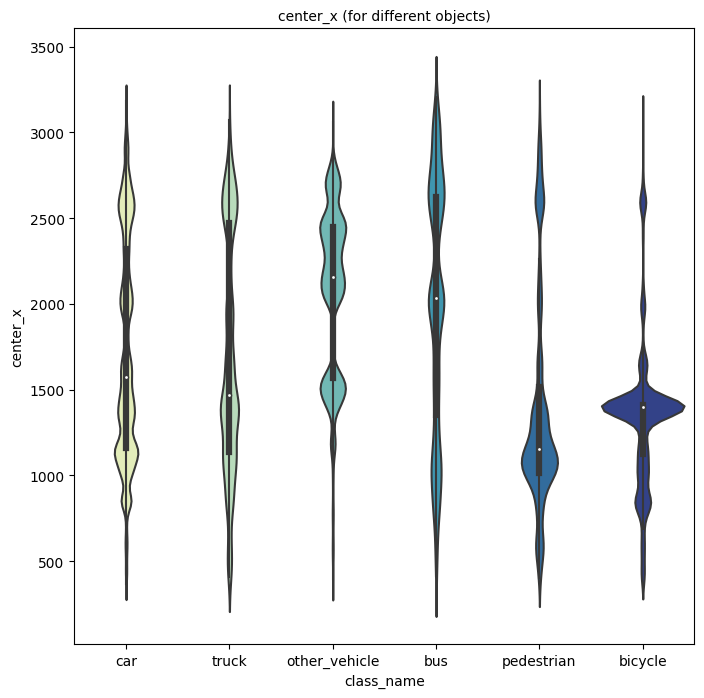

In [34]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_x", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlGnBu',
    _title='center_x (for different objects)', 
    type_of_plot="violinplot")

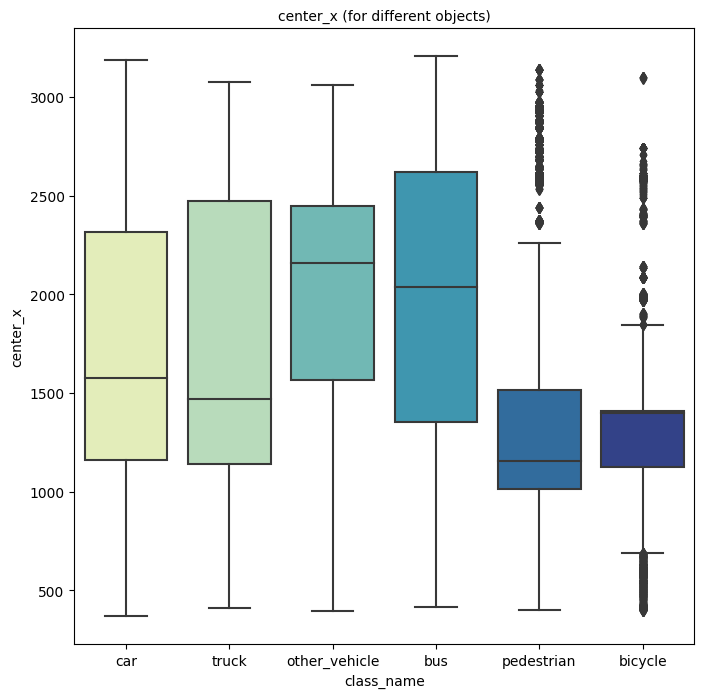

In [35]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_x",
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlGnBu',
    _title='center_x (for different objects)', 
    type_of_plot="boxplot")

### Notes

* Variation Across Classes:
    * All object classes show a spread of center_x values, but the central tendency and spread differ.
    * For example, cars, trucks, buses, and other vehicles cover a wide range, while pedestrians and bicycles are concentrated at lower center_x values.

* Class-Specific Locations:
    * Pedestrians and bicycles tend to cluster around lower center_x regions, visible as both denser violin sections and lower boxes.
    * This suggests these classes are often found closer to one side of the spatial axis (perhaps road edges or crosswalks).

* Central Tendency:
    * The median (white dot in violins, dark bar in boxes) shows cars/trucks/buses generally have higher medians than pedestrians/bicycles, highlighting road placement differences.

* Spread and Outliers:
    * Cars, trucks, and buses feature a large spread, visible in both the wide box range and broad violin density.
    * Pedestrians and bicycles exhibit more visible outliers and a tighter interquartile range.

* Skewness and Multimodality:
    * The violin plot reveals multimodal distributions for some classes (especially cars and other vehicles), indicating multiple preferred positions on the axis—implying the presence of lanes or frequent stopping locations.

* Density vs. Frequency:
    * Both plots reflect the frequency and density of objects at each position.
    * Where the violin widens or the box has many dots, more objects are present at that location.

### 2.2.10 `center_y` vs `class_name`

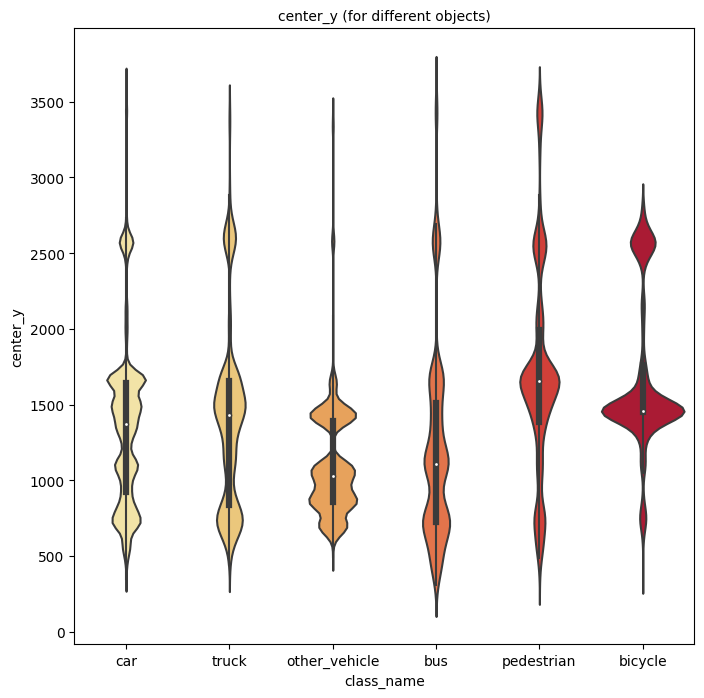

In [36]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_y", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlOrRd',
    _title='center_y (for different objects)', 
    type_of_plot="violinplot")

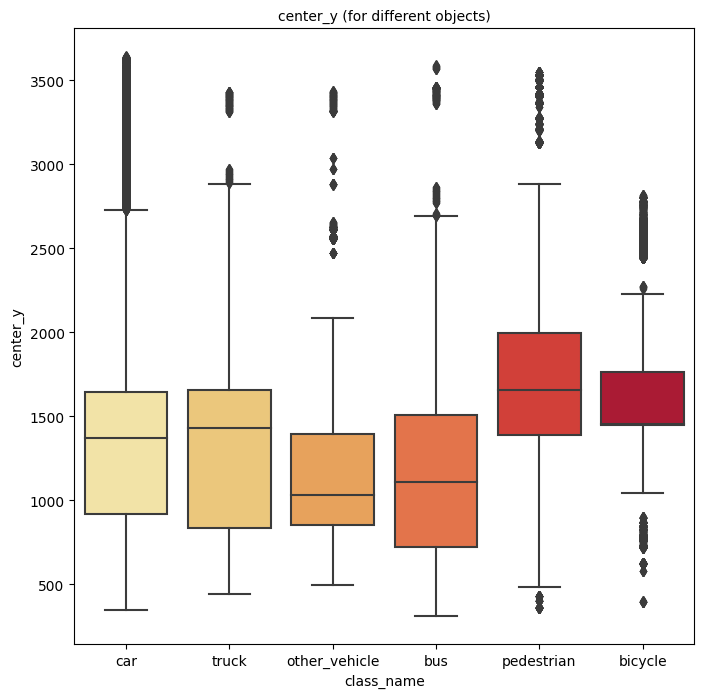

In [37]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_y", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlOrRd',
    _title='center_y (for different objects)', 
    type_of_plot="boxplot")

### Notes

* Spread and Range by Class:
    * Every object class shows a wide range of center_y positions, though the interquartile range (the colored section in the box, the thickest part of the violin) and the spread differ between classes.

* Class-Specific Densities:
    * As with center_x, heavier vehicles (car, truck, other_vehicle, bus) typically have broader and multi-peaked distributions, indicating that these classes appear across a large part of the y-axis (road width or positional field).

* Central Tendency:
    * The median lines (white dots in the violin, middle line in the boxplot) show that the typical center_y for cars, trucks, and buses lies lower than for pedestrian and bicycle.
    * Pedestrians and bicycles have higher median center_y values, indicating these objects often appear further in one direction (possibly closer to sidewalks or road edges)

* Multiple Modes:
    * The violin plot makes it clear that some classes show multimodal distributions (multiple peaks and valleys), which reflects the existence of commonly occupied regions—such as parallel lanes, crossing areas, or traffic patterns.

* Outliers and Extreme Values:
    * The boxplot shows outliers for all classes, but especially for pedestrian and bicycle, suggesting occasional detections far from the typical region (possibly crossing or sidewalk areas).

* Comparison Across Classes:
    * Cars, trucks, and buses share some overlap in their spatial distributions but remain clearly distinguishable from pedestrians and bicycles.
    * Pedestrians and bicycles are more tightly clustered around certain y values, reflected in smaller boxes and more peaked violins.


### 2.2.11 `center_z` vs `class_name`

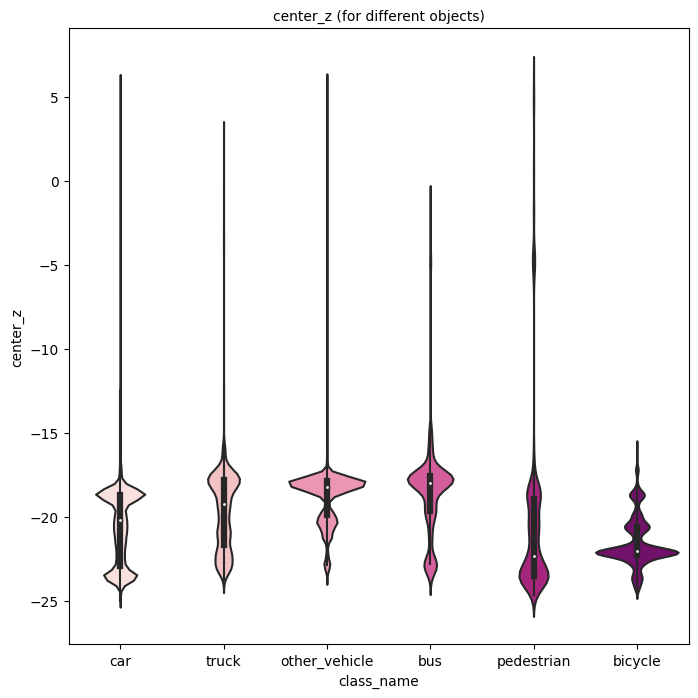

In [38]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_z", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='RdPu',
    _title='center_z (for different objects)', 
    type_of_plot="violinplot")

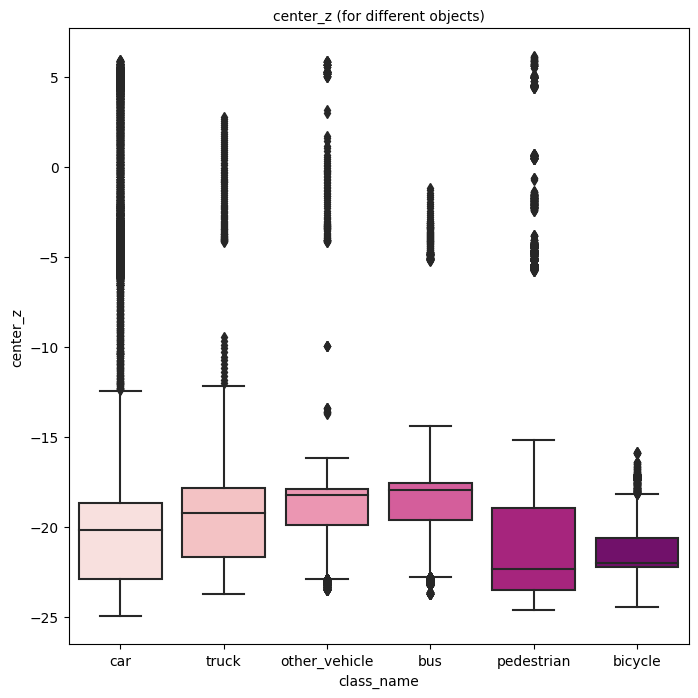

In [39]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="center_z", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='RdPu',
    _title='center_z (for different objects)', 
    type_of_plot="boxplot")

### Notes

* Typical Heights Differ by Class:
    * Cars, trucks, buses, and other vehicles have center_z (height) values that generally cluster around -20 to -15 (units depend on dataset, often meters or centimeters but negative means below a reference plane, usually the LiDAR or camera origin).
    * Pedestrians and bicycles are often even lower, reflecting that their bounding box centers are closer to the ground.

* Range and Outliers:
    * Every class contains a spread of values, but almost all vehicle types exhibit a wider interquartile range and more outliers than bicycles and pedestrians.
    * Many outliers exist above the typical "ground level," suggesting rare annotation points, elevated objects, or labeling noise.

* Peaks and Modal Concentration:
    * The violin plot shows that for most classes, there are concentrated peaks (higher density), indicating common box center heights, with some classes showing multi-modal distributions (multiple bands).
    * This is most visible for cars and trucks, which often have both a main peak and secondary densities at different heights.

* Pedestrian and Bicycle Distributions:
    * The range for pedestrians and bicycles is tighter and lower, and also sometimes includes extreme outliers (perhaps due to mounting errors, sidewalk curbs, or annotation artifacts).


### 2.2.12 `width` vs `class_name`

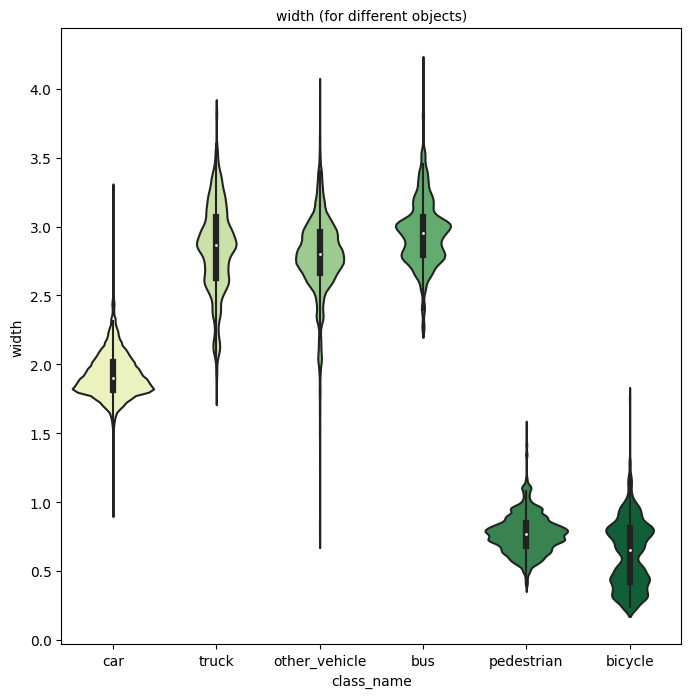

In [40]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="width", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlGn',
    _title='width (for different objects)', 
    type_of_plot="violinplot")

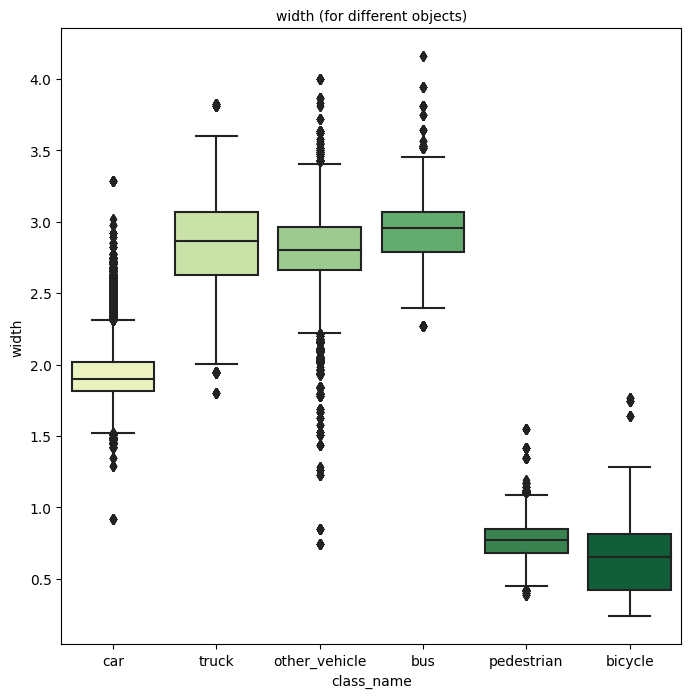

In [41]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="width", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='YlGn',
    _title='width (for different objects)', 
    type_of_plot="boxplot")

### Notes

* Clear Class Separation:
    * Vehicle classes (truck, other_vehicle, bus) have much larger widths (centered near 3.0) compared to cars and especially compared to pedestrians and bicycles, which have widths less than 1.0.

* Consistent Ordering:
    * The median width increases from pedestrians and bicycles (smallest), to cars (medium), to trucks, other vehicles, and buses (widest).
    * This matches real-world expectations for object width in autonomous driving data.

* Narrow vs. Wide Spread:
    * Pedestrians and bicycles not only have the smallest average width, but also the narrowest interquartile range (both plots), indicating consistency in object size.
    * Cars and especially heavy vehicles show more variation in width.

* Multimodality and Density Peaks:
    * The violin plot reveals multiple peaks for trucks, other vehicles, and buses, suggesting subclasses or annotation clusters (e.g., different vehicle types or annotation standards).

* Outlier Presence:
    * Boxplots show outliers especially for the car and heavy vehicle classes.
    * Some outlier widths for pedestrians and bicycles may indicate annotation noise or unusual scenarios (groups, occlusions, or side-view errors).

* Violin and Boxplot Consistency:
    * Both plots support each other's findings: the dense, fat regions of the violins correspond to the box heights in the boxplot.

### 2.2.13 `length` vs `class_name`

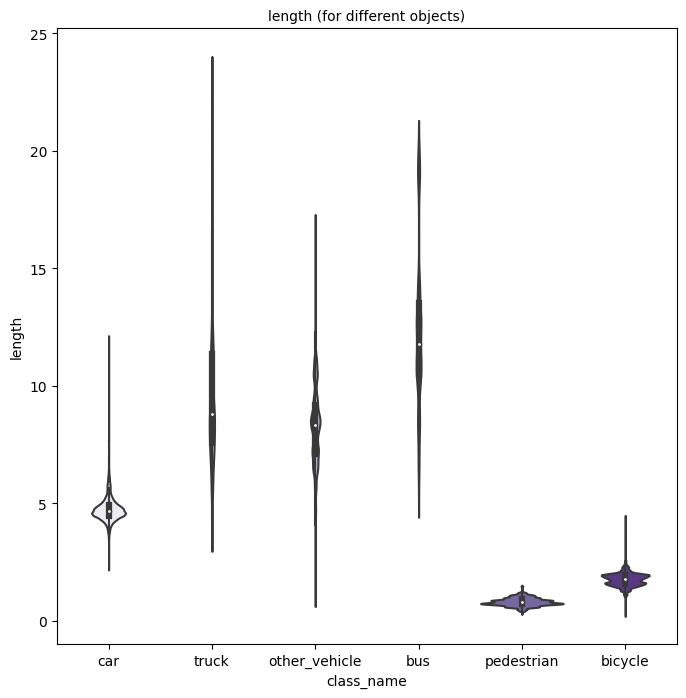

In [42]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="length", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='Purples',
    _title='length (for different objects)', 
    type_of_plot="violinplot")

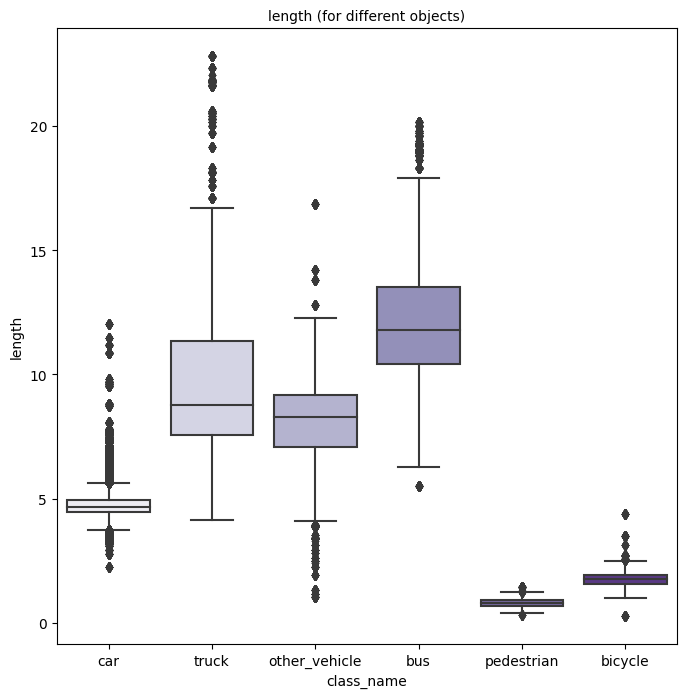

In [43]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="length", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='Purples',
    _title='length (for different objects)', 
    type_of_plot="boxplot")

### Notes

* Length Orders Reflect Reality:
    * Buses have the highest median length, followed by trucks and other vehicles.
    * Cars have a lower median and less spread than the larger vehicles, while pedestrians and bicycles exhibit the smallest lengths.

* Well-Separated Classes:
    * There’s a distinct separation between vehicle classes (car, truck, other_vehicle, bus), which have much greater lengths, versus non-vehicle classes (pedestrian, bicycle), which are much shorter on average.

* Spread and Outliers:
    * Vehicles, especially trucks and buses, show a wide range and many outliers (visible as dots above the boxes and as tails on the violins), signaling substantial physical variation and possibly annotation outliers.
    * Pedestrians and bicycles have tighter interquartile ranges and fewer extreme outliers, reflecting greater uniformity in bounding box length.

* Multimodal and Right-Skewed Distributions:
    * In the violin plot, several vehicle categories appear to have long tails or multiple peaks, suggesting diversity in vehicle subtypes, perspectives, or scene conditions.
    * Cars (and to some extent bicycles and pedestrians) display tighter and more unimodal distributions.

* Consistent Patterns in Both Plots:
    * Both plots convey that objects in your data conform to real-world object length rankings, with so-called “heavy” vehicles substantially exceeding both cars and vulnerable road users (pedestrian/bicycle).

### 2.2.14 `height` vs `class_name`

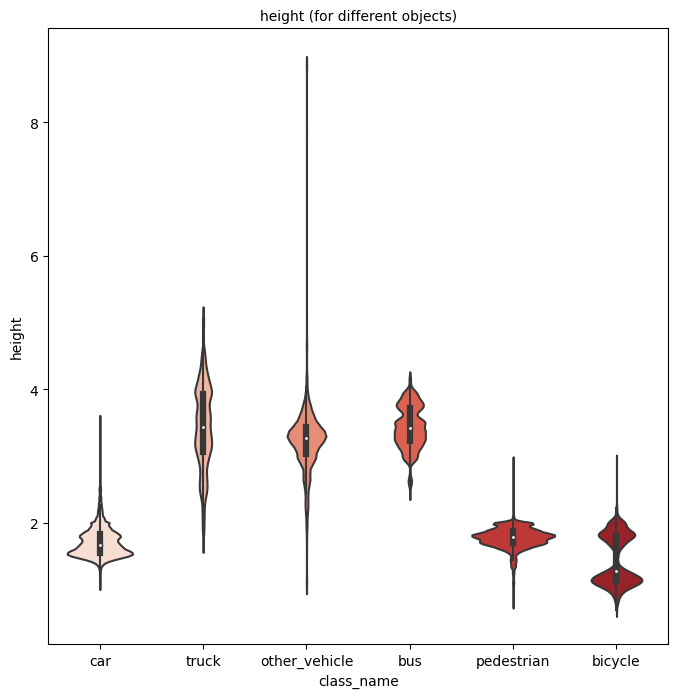

In [44]:
comparison_plots(
    df_train_objects,
    _x="class_name",
    _y="height", 
    _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
    _palette='Reds',
    _title='height (for different objects)', 
    type_of_plot="violinplot")

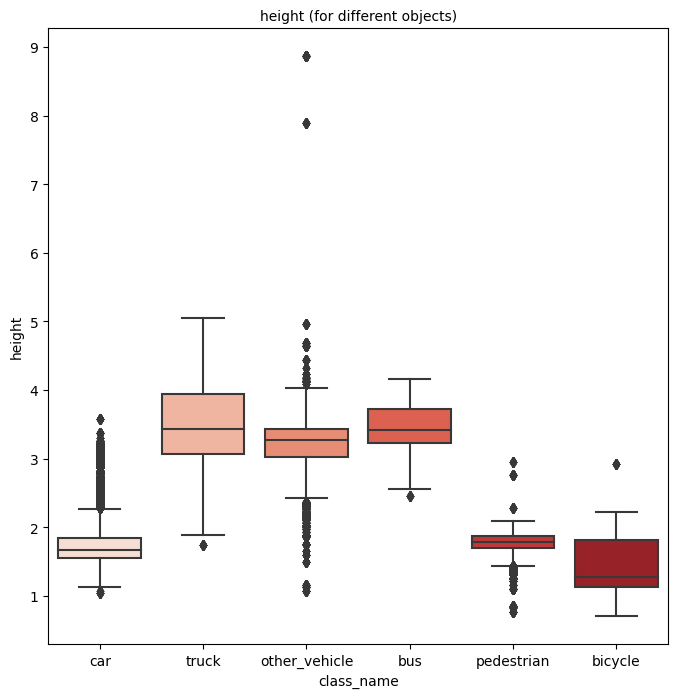

In [45]:
comparison_plots(df_train_objects, _x="class_name", _y="height", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='Reds',
                 _title='height (for different objects)', 
                 type_of_plot="boxplot")

### Notes

* Height Ranks by Class:
    * Trucks, buses, and other heavy vehicles have the highest typical heights, with medians around 3 to 4 units. Cars rank lower, while pedestrians and bicycles are the shortest object classes.

* Distinct Separation:
    * There's clear visual separation in median height between object classes—heavy vehicles are consistently taller than cars, which are taller than pedestrians and bicycles.

* Tight Spread for Non-Vehicles:
    * Pedestrians and bicycles show smaller interquartile ranges and less spread. Their heights are concentrated and less variable, as expected given the physical constraints of people and bicycles.

* Outliers and Maximums:
    * Every class has some outliers, but especially trucks, other vehicles, and buses, reflecting a combination of rare very tall vehicles, potential annotation errors, or stacked/double-decker types.
    * A few extreme outliers (as seen in the boxplot) may signal annotation anomalies.

* Density Peaks and Modalities:
    * Violin plots reveal where most measurements cluster—the fattest parts are the most common heights for each class.
    * Cars and heavy vehicles usually have a primary mode, while a more complex shape for buses, trucks, or other vehicles suggests multiple subtypes or sample characteristics.